<a href="https://colab.research.google.com/github/zolachu/cs145_project3/blob/main/final_project3_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS145: Project 3 | StackOverFlow Users table exploration

## Project Overview

------ 

We’ll look at StackOverFlow as our exploration dataset, specifically focus on the `users` table to find relations between its columns. In addition, we’ll train, evaluate some features of this table and test the resulting model on a test dataset extracted from the `users` table. 

-----

In [1]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project3-294103"

In [2]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'stackoverflow'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

## Analysis of Dataset



---

In this project, I will only use StackOverFlow data taken from year 2010 (the users who created their account in year 2010). The `users` table comprises 2.023 GB of data. Our goal will be to predict the reputation of users. Low reputation is linked to low up_votes, more down_votes, and low views. 

---

In [129]:
%%bigquery --project $project_id

select sum(size_bytes)/(1024*1024*1024) as size_GB
from `bigquery-public-data.stackoverflow.`.__TABLES__
where table_id = 'users'

,size_GB
0,2.023294


------

We will use the following columns to make our model:



*   reputation: Reputation of a user,
*   creation_date: the date when the user created their account
*   up_votes: the number of upvotes
*   down_votes: the number of downvotes of the user
*   views: the number of total views
* profile_image_url: 1 if the user has profile image, 0 otherwise

* website_url: 1 if the user has website, 0 otherwise.


------

-------

The average reputation length is 119.

-------

In [120]:
%%bigquery --project $project_id

SELECT AVG(reputation) as reputation
FROM `bigquery-public-data.stackoverflow.users`
WHERE reputation IS NOT NULL 

,reputation
0,118.11372


## Data Exploration

In [72]:
%%bigquery --project $project_id users_data

SELECT IF(reputation = 0, 1, reputation) as reputation,
      BYTE_LENGTH(about_me) as about_me_length, 
      creation_date,
      IF(up_votes = 0, 1, up_votes) as up_votes,
      IF(down_votes = 0, 1, down_votes) as down_votes,
      IF(views = 0, 1, views) as views,
      IF(profile_image_url IS NULL, 0, 1) as has_profile_image, 
      IF(website_url is NULL, 0, 1) as has_website_url,
FROM `bigquery-public-data.stackoverflow.users`
WHERE DATE(creation_date) between '2010-01-01' AND '2010-11-01' 
      and about_me is NOT NULL
      and up_votes is NOT NULL 
      and down_votes is NOT NULL
      and reputation is NOT NULL

--------

The `users_data` table looks like the following: 

---------

In [73]:
display(users_data)

,reputation,about_me_length,creation_date,up_votes,down_votes,views,has_profile_image,has_website_url
0,3366,19,2010-01-15 17:25:11.137000+00:00,2089,43,299,0,0
1,2062,106,2010-04-25 09:13:05.827000+00:00,79,29,154,0,0
2,10688,512,2010-05-19 01:54:08.833000+00:00,1492,514,2620,0,1
3,3487,35,2010-05-19 12:45:49.680000+00:00,309,40,515,0,1
4,1751,72,2010-05-29 16:05:29.420000+00:00,91,22,376,1,0
...,...,...,...,...,...,...,...,...
28686,15800,1031,2010-09-19 19:30:46.257000+00:00,1853,18,1388,1,1
28687,5919,48,2010-09-22 04:54:59.537000+00:00,478,18,226,0,1
28688,5074,95,2010-09-22 05:22:45.167000+00:00,349,18,893,1,1
28689,6144,97,2010-10-13 11:51:34.743000+00:00,2419,18,433,1,0


--------- 

### Feature exploration

-------

In [34]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

--------

The plot of sample `Log(reputation) vs Log(up_votes)` indicates that there is a linear relationship trend between log(reputation) and log(up_votes) since we can see diagonal line formed by the sample points. 

--------

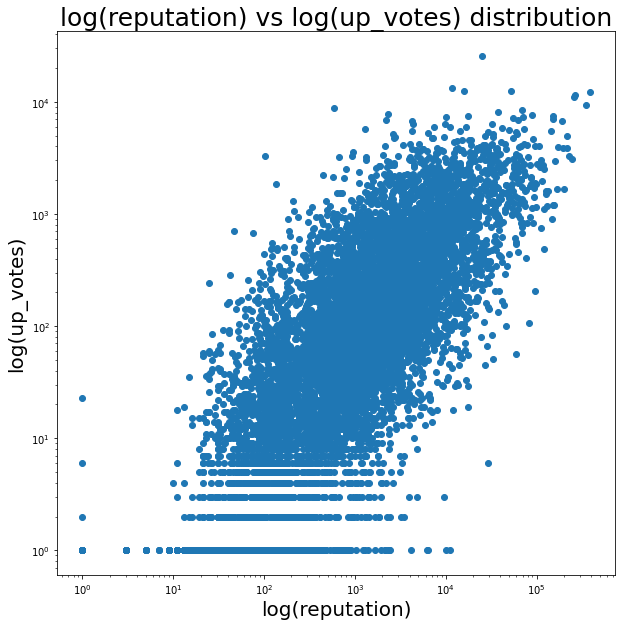

In [117]:
%matplotlib inline

df = pd.DataFrame({"x" : users_data["reputation"], "y" : users_data["up_votes"]})
sample_df = df.sample(n = 10000, replace=False, random_state=0)
plt.figure(figsize=(10,10))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("log(reputation)", fontsize=20)
plt.ylabel("log(up_votes)", fontsize=20)
plt.title("log(reputation) vs log(up_votes) distribution", fontsize=25)
plt.scatter(sample_df["x"], sample_df["y"])

------

The plot of sample `Log(reputation) vs Log(down_votes)` indicates that there could be a linear relationship trend between log(reputation) and log(down_votes).

---------

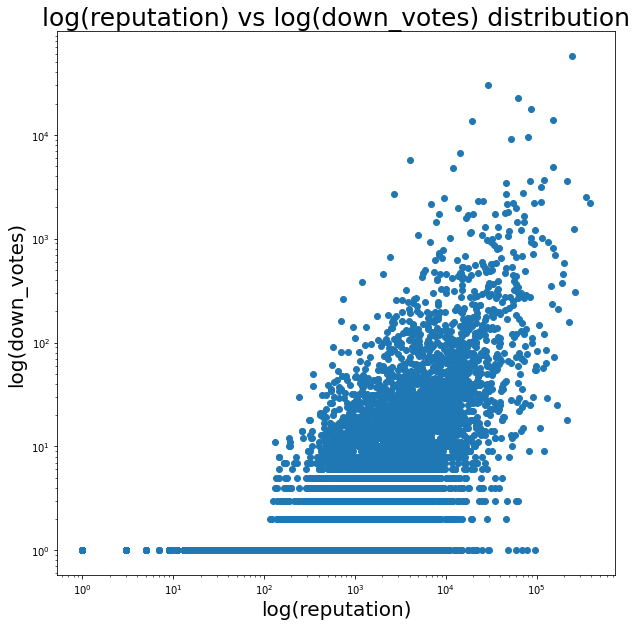

In [116]:
%matplotlib inline

df = pd.DataFrame({"x" : users_data["reputation"], "y" : users_data["down_votes"]})
sample_df = df.sample(n = 10000, replace=False, random_state=0)
plt.figure(figsize=(10,10))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("log(reputation)", fontsize=20)
plt.ylabel("log(down_votes)", fontsize=20)
plt.title("log(reputation) vs log(down_votes) distribution", fontsize=25)
plt.scatter(sample_df["x"], sample_df["y"])

------

The plot of sample `Log(up_votes) vs Log(views)` indicates that there is a linear relationship trend between log(up_votes) and log(views) since we can see diagonal line formed by the sample points.  

------

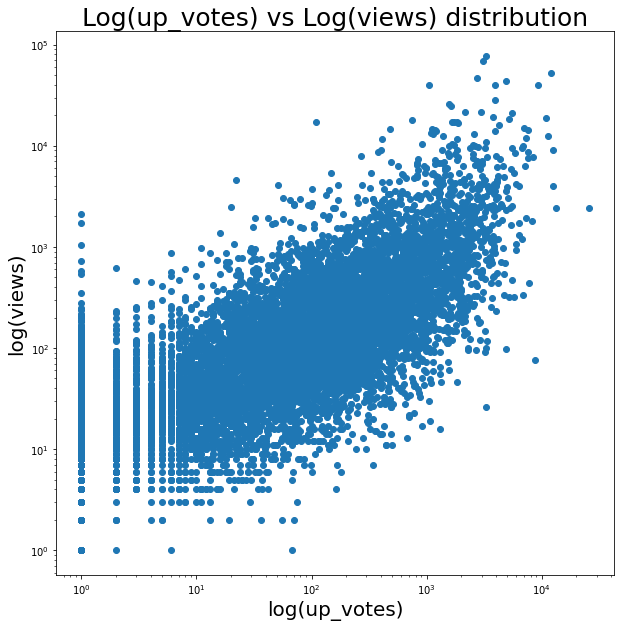

In [96]:
%matplotlib inline

df = pd.DataFrame({"x" : users_data["up_votes"], "y" : users_data["views"]})
sample_df = df.sample(n = 10000, replace=False, random_state=0)
plt.figure(figsize=(10,10))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("log(up_votes)", fontsize=20)
plt.ylabel("log(views)", fontsize=20)
plt.title("Log(up_votes) vs Log(views) distribution", fontsize=25)
plt.scatter(sample_df["x"], sample_df["y"])

We save the resulting table in `cs145-project3-294103.stackoverflow.users_table` (where date_creation is all dates, not just 2010)

## Data Prediction

------

We will split `Stackoverflow` data in year 2010 to training set (`creation_date` is between '2010-01-01' AND '2010-11-01'), evaluation set (`creation_date` between '2010-11-01' AND '2010-12-01'), and test set (`creation_date` between '2010-12-01' AND '2011-01-01').

We will create our model `stackoverflow.users_model` and specify the model type as linear_regression, and the label as log(reputation). (We want to use linear regression because we are predicting a continuous quantity, i.e reputation.)

-----

In [111]:
%%bigquery --project $project_id 

CREATE OR REPLACE MODEL `stackoverflow.users_model` 
OPTIONS (model_type='linear_reg') AS
SELECT log(reputation, 2) as label,
      about_me_length as feature1, 
      log(up_votes, 2) as feature3,
      log(down_votes, 2) as feature4,
      views as feature5,
      has_profile_image as feature6, 
      has_website_url as feature7,
FROM `cs145-project3-294103.stackoverflow.users_table`
WHERE (DATE(creation_date) between '2010-01-01' AND '2010-11-01')

""


In [138]:
%%bigquery --project $project_id

SELECT * FROM 
 ML.TRAINING_INFO(MODEL `stackoverflow.users_model`)


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,3.952189,3.830492,None,3306


In [139]:
%%bigquery --project $project_id

SELECT
  input, min, max, mean, stddev
FROM
  ml.FEATURE_INFO(MODEL `stackoverflow.users_model`) AS model

,input,min,max,mean,stddev
0,feature1,1.0,5907.000000,181.308238,292.611868
1,feature3,0.0,14.913731,5.308076,3.421662
2,feature4,0.0,15.807229,1.547829,2.212191
3,feature5,1.0,77046.000000,403.045048,1887.866075
4,feature6,0.0,1.000000,0.208808,0.406466
5,feature7,0.0,1.000000,0.634005,0.481719


We will evaluate the trained model on the unseen data (creation date between 2010-11-01 and 2010-12-01). 

In [113]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflow.users_model`, (
SELECT log(reputation, 2) as label,
      about_me_length as feature1, 
      log(up_votes, 2) as feature3,
      log(down_votes, 2) as feature4,
      views as feature5,
      has_profile_image as feature6, 
      has_website_url as feature7,
FROM `cs145-project3-294103.stackoverflow.users_table`
WHERE (DATE(creation_date) between '2010-11-01' AND '2010-12-01')))


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.557341,4.27947,0.226869,1.176654,0.658296,0.659492


Now that we have trained our data and evaluated on the evaluation dataset, we will predict it on a new data set (creation date between 2010-12-01 and 2011-01-01). 

We will randomly print out 2/1000 of the test data. 

In [115]:
%%bigquery --project $project_id

SELECT
  label,
  predicted_label
FROM
  ML.PREDICT(MODEL `stackoverflow.users_model`, ( 
SELECT log(reputation, 2) as label,
      about_me_length as feature1, 
      log(up_votes, 2) as feature3,
      log(down_votes, 2) as feature4,
      views as feature5,
      has_profile_image as feature6, 
      has_website_url as feature7,
FROM `cs145-project3-294103.stackoverflow.users_table`
WHERE (DATE(creation_date) between '2010-12-01' AND '2011-01-01')))
WHERE rand() < 0.002

,label,predicted_label
0,12.746934,11.457102
1,5.426265,4.956440
2,0.000000,4.820331
3,11.221587,9.249843
4,6.700440,7.641745
5,9.276124,10.218649
6,11.116344,11.725399
7,11.864573,12.565717
8,4.392317,5.207814


In [142]:
%%bigquery --project $project_id

SELECT
  power(2, predicted_label) as predicted_reputation, 
  feature1 as about_me_length, 
  power(2, feature3) as up_votes ,
  power(2, feature4) as down_votes,
  feature5 as views, 
  feature6 as has_profile_image, 
  feature7 as has_website_url,

FROM
  ML.PREDICT(MODEL `stackoverflow.users_model`, ( 
SELECT log(reputation, 2) as label,
      about_me_length as feature1, 
      log(up_votes, 2) as feature3,
      log(down_votes, 2) as feature4,
      views as feature5,
      has_profile_image as feature6, 
      has_website_url as feature7,
FROM `cs145-project3-294103.stackoverflow.users_table`
WHERE (DATE(creation_date) between '2010-12-01' AND '2011-01-01')))
WHERE rand() < 0.002

,predicted_reputation,about_me_length,up_votes,down_votes,views,has_profile_image,has_website_url
0,3052.356343,107,375.0,11.0,73,0,0
1,196.673549,23,17.0,1.0,23,0,0
2,72.751495,9,4.0,1.0,5,0,0
3,2010.186403,152,193.0,9.0,70,1,1
4,28.389254,48,1.0,1.0,32,0,0
5,29.533786,268,1.0,1.0,15,1,0
6,1392.198948,49,260.0,1.0,80,1,1
7,215.405920,254,18.0,1.0,149,1,0
8,467.678245,61,59.0,1.0,63,1,0
9,31.112731,156,1.0,1.0,7,0,1


Moreover, we can test it on a different data set from 2011 - 2012 year. The result shows that even in 2011, the prediction looks accurate. (Out of curiousity, I tested the trained model on a different test set). 

In [127]:
%%bigquery --project $project_id

SELECT
  label,
  predicted_label
FROM
  ML.PREDICT(MODEL `stackoverflow.users_model`, ( 
SELECT log(reputation, 2) as label,
      about_me_length as feature1, 
      log(up_votes, 2) as feature3,
      log(down_votes, 2) as feature4,
      views as feature5,
      has_profile_image as feature6, 
      has_website_url as feature7,
FROM `cs145-project3-294103.stackoverflow.users_table`
WHERE (DATE(creation_date) between '2011-01-01' AND '2012-01-01')))
WHERE rand() < 0.0001

,label,predicted_label
0,12.497353,11.336680
1,6.870365,9.973782
2,4.754888,4.819066
3,0.000000,4.925549
4,6.507795,7.911705
5,7.247928,8.594053
6,10.843921,11.890499
7,13.827243,13.107645
8,13.991699,13.120951


## Conclusion

---

In this linear model training, we only evaluated the user accounts that were created in 2010. Although the model could successfully predict the year 2011, we definitely lack the ability to predict the recent years (2018- present). This limitation is due to the fact that the user accounts created in 2018-present don't have enough reputation, downvotes, upvotes, and views. 

In the model above, I excluded user accounts where one or more features and label were NULL. Also, if any values of views, reputation, up_votes, and down_votes are zero, I replaced them with 1's in order to use "log" scaling. 


---

-----

The result of the prediction: 
log(Reputation) is linearly related to about_me_length, log(up_votes), log(down_votes), views, has_profile_image, and has_website_url  features. 

-----